In [59]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/thuvu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/thuvu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
api_key = 'XXXX'

In [3]:
channel_ids = ['UCoOae5nYA7VqaXzerajD0lg',
               # more channels here
              ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [ ]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

channelName subscribers      views totalVideos                playlistId
0  Ali Abdaal     2610000  171864662         427  UUoOae5nYA7VqaXzerajD0lg

In [7]:
playlist_id = "UUoOae5nYA7VqaXzerajD0lg"

In [8]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [82]:
len(video_ids)

426

In [10]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

video_id channelTitle  \
0    FJwp5RBLQcs   Ali Abdaal   
1    lCrMAtbBUJA   Ali Abdaal   
2    6Dvkq5yAvcA   Ali Abdaal   
3    7hVqxhZaxtk   Ali Abdaal   
4    Dyliijbw_aQ   Ali Abdaal   
..           ...          ...   
422  7APfFjfnNBc   Ali Abdaal   
423  gBpBLTSCb4s   Ali Abdaal   
424  Va0tSdPADpA   Ali Abdaal   
425  XJHM0fEH3ss   Ali Abdaal   
426  LQ3Mu8A7gjY   Ali Abdaal   

                                                 title  \
0                             My New Life Goals (2022)   
1                             15 Books To Read In 2022   
2                    21 Life Lessons I Learned in 2021   
3                       How I Spent $1,625,483 in 2021   
4    5 Lessons from Atomic Habits in Under 60 Secon...   
..                                                 ...   
422  Payphone (Maroon 5) - Katherine Macfarland & A...   
423            6med UKCAT Crash Course - In a Nutshell   
424             6med BMAT Crash Course - In a Nutshell   
425  Rolling in the Deep (Adele) - Duranka Perera &...   
426           All of Me (John Legend) - Duranka Perera   

                                           description  \
0    Notion - https://ntn.so/aliabdaalnotion\n\nIn ...   
1    To improve your thinking and learn new skills,...   
2    To improve your thinking and learn new skills,...   
3    In this video, I go over my annual expenses fo...   
4    In “Atomic Habits”, James Clear teaches us how...   
..                                                 ...   
422  First cover of 2017! We both love this song, s...   
423  The 6med UKCAT Crash Course is the most effect...   
424  The 6med BMAT Crash Course is the most effecti...   
425  Our first 'proper' video! One of our all-time ...   
426  First attempt at playing around with this sort...   

                                                  tags           publishedAt  \
0    [Ali Abdaal, Ali abdal, Life Goals, 2022 goals...  2022-01-21T15:35:53Z   
1    [Ali Abdaal, Ali abdal, Ali abdaal Reading, Al...  2022-01-07T15:00:21Z   
2    [Ali Abdaal, Ali abdal, 2020 life lessons, top...  2022-01-04T17:02:55Z   
3    [Ali Abdaal, Ali abdal, how much money I REALI...  2021-12-24T15:00:05Z   
4    [Ali Abdaal, Ali abdal, Atomic Habits, Atomic,...  2021-12-21T14:30:05Z   
..                                                 ...                   ...   
422        [payphone, maroon 5, acoustic cover, cover]  2017-01-04T23:13:51Z   
423            ed, medical school, ukcat, medicine]  2016-05-09T18:45:18Z   
424           [BMAT, 6med, medicine, medical students]  2016-04-27T09:04:49Z   
425      [rolling in the deep, adele, cover, acoustic]  2016-04-05T09:05:29Z   
426                                               None  2016-03-27T19:30:11Z   

    viewCount likeCount favouriteCount commentCount  duration definition  \
0       75489      4019           None          323  PT21M16S         hd   
1      322907     14862           None          809  PT23M18S         hd   
2      275899     13358           None          788  PT27M37S         hd   
3      254800      9973           None          912  PT21M27S         hd   
4      203402     15318           None          147     PT47S         hd   
..        ...       ...            ...          ...       ...        ...   
422     65292      1733           None          106   PT2M35S         hd   
423     11697        82           None            4   PT2M11S         hd   
424     29495       222           None            8   PT2M18S         hd   
425     38957       480           None           25   PT2M29S         hd   
426     77390       971           None          102   PT1M43S         hd   

    caption  
0     false  
1     false  
2     false  
3     false  
4     false  
..      ...  
422   false  
423   false  
424   false  
425   false  
426   false  

[427 rows x 13 columns]

## Data pre-processing

In [11]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [12]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [13]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [14]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [17]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [30]:
video_df[['durationSecs', 'duration']] 

durationSecs  duration
0          1276.0  PT21M16S
1          1398.0  PT23M18S
2          1657.0  PT27M37S
3          1287.0  PT21M27S
4            47.0     PT47S
..            ...       ...
422         155.0   PT2M35S
423         131.0   PT2M11S
424         138.0   PT2M18S
425         149.0   PT2M29S
426         103.0   PT1M43S

[427 rows x 2 columns]

In [34]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [36]:
video_df

video_id channelTitle  \
0    FJwp5RBLQcs   Ali Abdaal   
1    lCrMAtbBUJA   Ali Abdaal   
2    6Dvkq5yAvcA   Ali Abdaal   
3    7hVqxhZaxtk   Ali Abdaal   
4    Dyliijbw_aQ   Ali Abdaal   
..           ...          ...   
422  7APfFjfnNBc   Ali Abdaal   
423  gBpBLTSCb4s   Ali Abdaal   
424  Va0tSdPADpA   Ali Abdaal   
425  XJHM0fEH3ss   Ali Abdaal   
426  LQ3Mu8A7gjY   Ali Abdaal   

                                                 title  \
0                             My New Life Goals (2022)   
1                             15 Books To Read In 2022   
2                    21 Life Lessons I Learned in 2021   
3                       How I Spent $1,625,483 in 2021   
4    5 Lessons from Atomic Habits in Under 60 Secon...   
..                                                 ...   
422  Payphone (Maroon 5) - Katherine Macfarland & A...   
423            6med UKCAT Crash Course - In a Nutshell   
424             6med BMAT Crash Course - In a Nutshell   
425  Rolling in the Deep (Adele) - Duranka Perera &...   
426           All of Me (John Legend) - Duranka Perera   

                                           description  \
0    Notion - https://ntn.so/aliabdaalnotion\n\nIn ...   
1    To improve your thinking and learn new skills,...   
2    To improve your thinking and learn new skills,...   
3    In this video, I go over my annual expenses fo...   
4    In “Atomic Habits”, James Clear teaches us how...   
..                                                 ...   
422  First cover of 2017! We both love this song, s...   
423  The 6med UKCAT Crash Course is the most effect...   
424  The 6med BMAT Crash Course is the most effecti...   
425  Our first 'proper' video! One of our all-time ...   
426  First attempt at playing around with this sort...   

                                                  tags  \
0    [Ali Abdaal, Ali abdal, Life Goals, 2022 goals...   
1    [Ali Abdaal, Ali abdal, Ali abdaal Reading, Al...   
2    [Ali Abdaal, Ali abdal, 2020 life lessons, top...   
3    [Ali Abdaal, Ali abdal, how much money I REALI...   
4    [Ali Abdaal, Ali abdal, Atomic Habits, Atomic,...   
..                                                 ...   
422        [payphone, maroon 5, acoustic cover, cover]   
423            ed, medical school, ukcat, medicine]   
424           [BMAT, 6med, medicine, medical students]   
425      [rolling in the deep, adele, cover, acoustic]   
426                                               None   

                  publishedAt  viewCount  likeCount  favouriteCount  \
0   2022-01-21 15:35:53+00:00    75489.0     4019.0             NaN   
1   2022-01-07 15:00:21+00:00   322907.0    14862.0             NaN   
2   2022-01-04 17:02:55+00:00   275899.0    13358.0             NaN   
3   2021-12-24 15:00:05+00:00   254800.0     9973.0             NaN   
4   2021-12-21 14:30:05+00:00   203402.0    15318.0             NaN   
..                        ...        ...        ...             ...   
422 2017-01-04 23:13:51+00:00    65292.0     1733.0             NaN   
423 2016-05-09 18:45:18+00:00    11697.0       82.0             NaN   
424 2016-04-27 09:04:49+00:00    29495.0      222.0             NaN   
425 2016-04-05 09:05:29+00:00    38957.0      480.0             NaN   
426 2016-03-27 19:30:11+00:00    77390.0      971.0             NaN   

     commentCount  duration definition caption pushblishDayName  durationSecs  \
0           323.0  PT21M16S         hd   false           Friday        1276.0   
1           809.0  PT23M18S         hd   false           Friday        1398.0   
2           788.0  PT27M37S         hd   false          Tuesday        1657.0   
3           912.0  PT21M27S         hd   false           Friday        1287.0   
4           147.0     PT47S         hd   false          Tuesday          47.0   
..            ...       ...        ...     ...              ...           ...   
422         106.0   PT2M35S         hd   false        Wednesday         155.0   
423           4.0   PT

## EDA

### Best performing videos

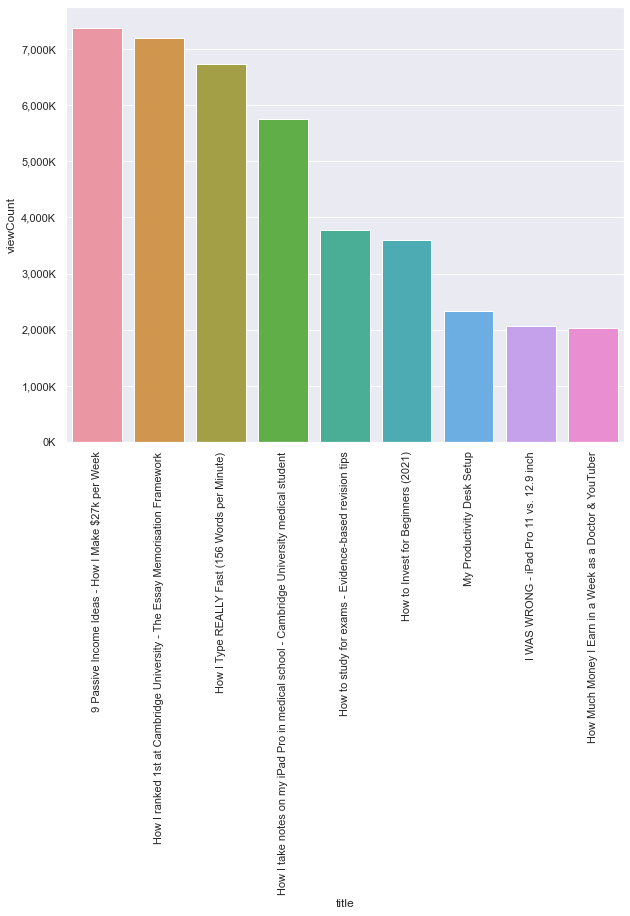

In [41]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst performing videos

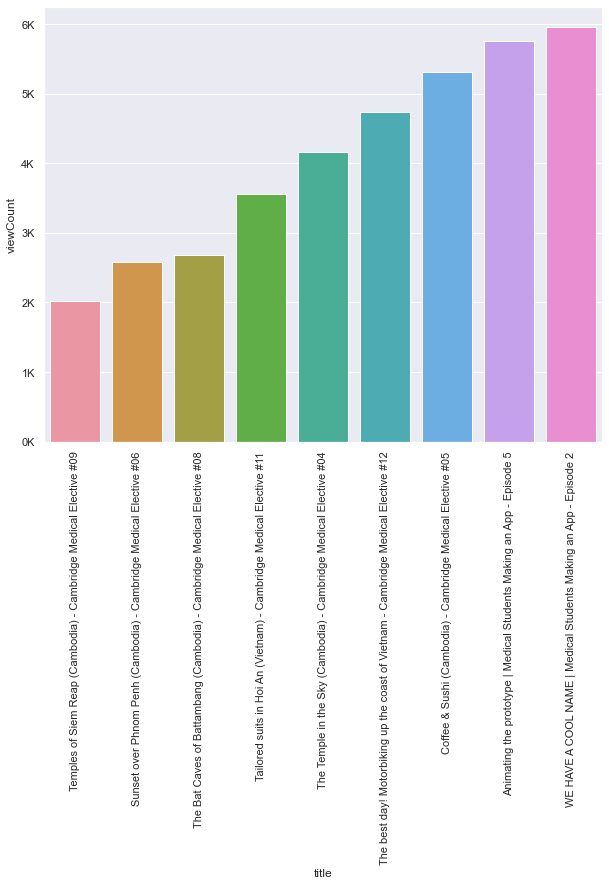

In [42]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

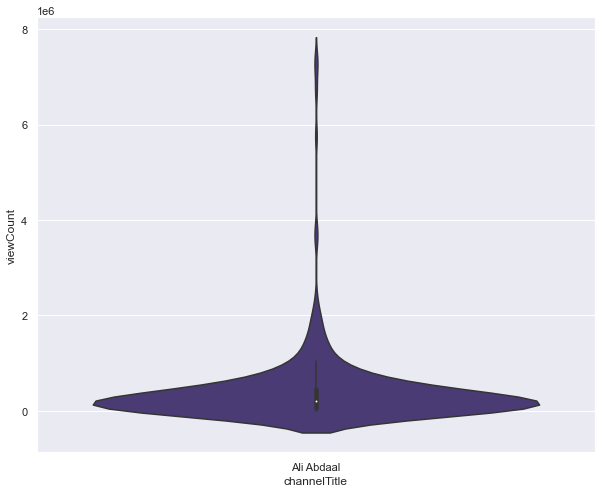

In [43]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

### Views vs. likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

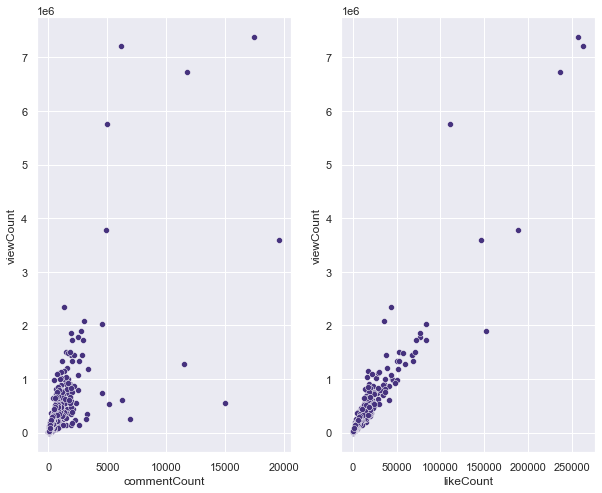

In [49]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Video duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

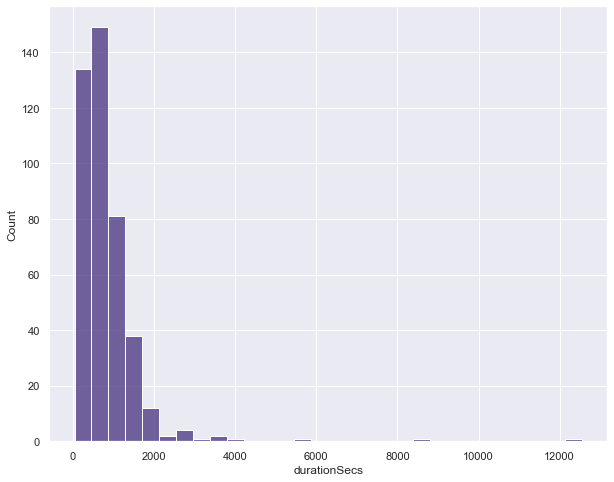

In [50]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

### Wordcloud for video titles

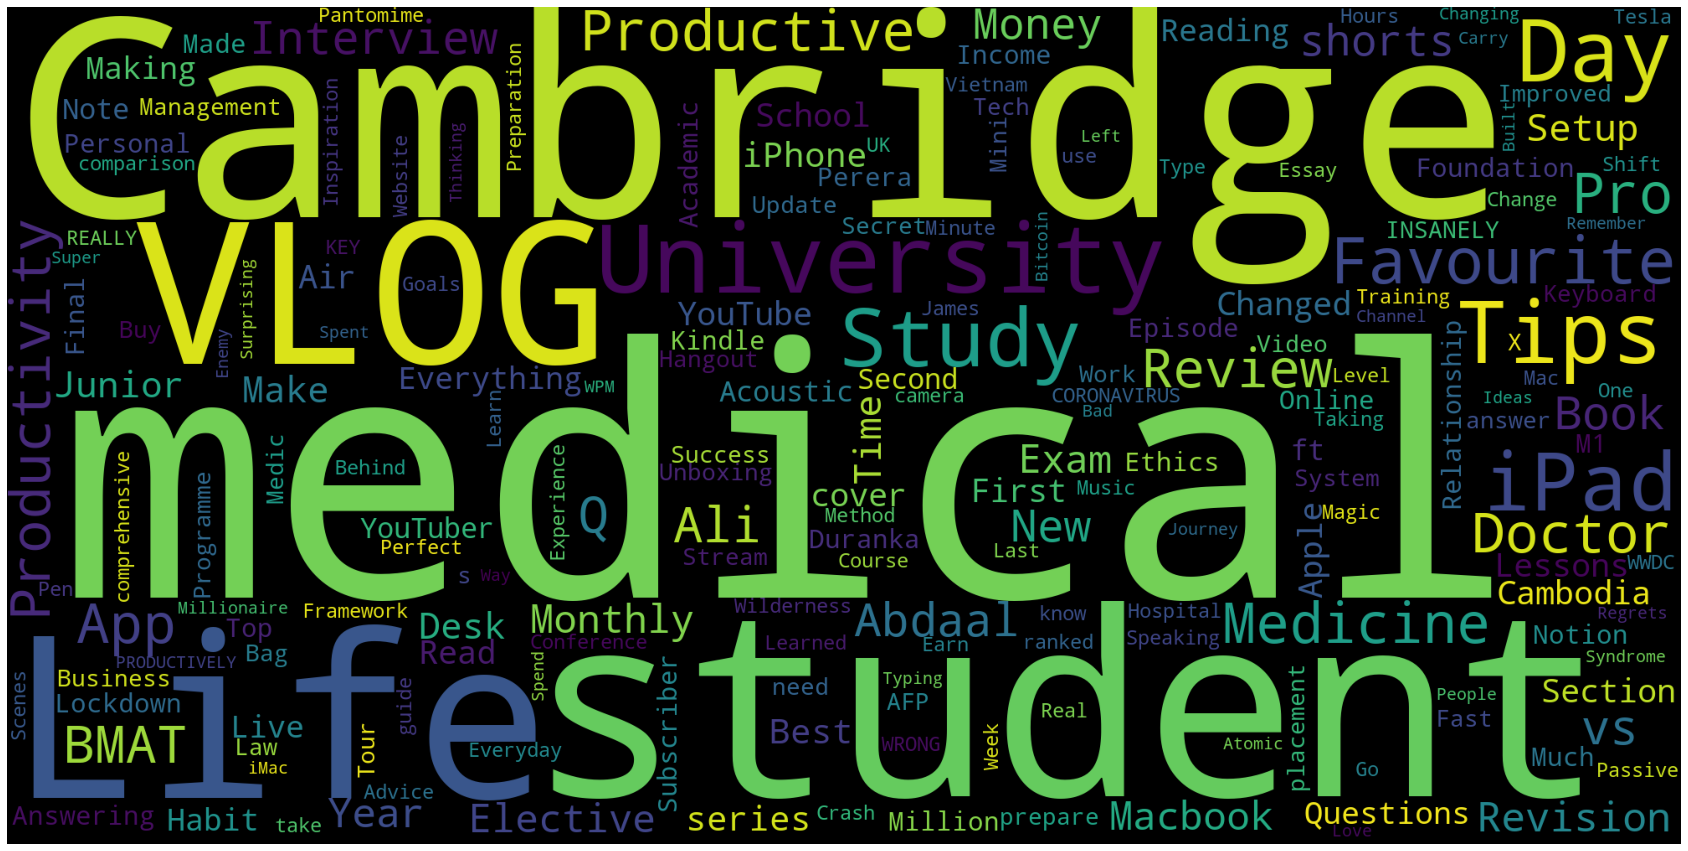

In [57]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Upload schedule

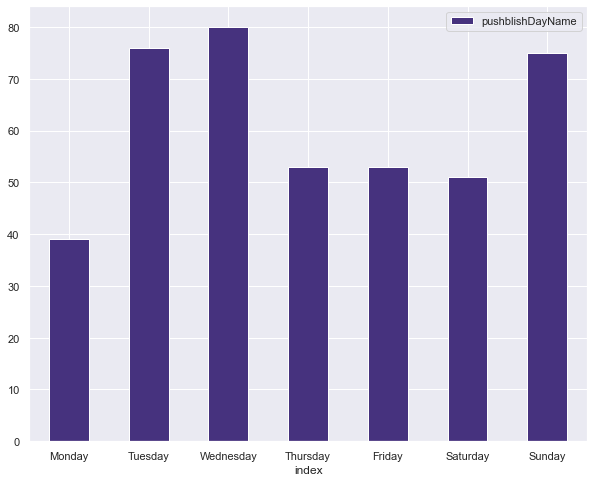

In [58]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)